## About

This starter code shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. It will install [OpenSlide](https://openslide.org/) in Colab (the only non-Python dependency). Note that OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom), shown in class. To use that, you'll need to install and run OpenSlide locally on your computer.

### Training data

The original slides and annotations are in an unusual format. I converted a bunch of them for you, so you can read them with OpenSlide as shown in this notebook. This [folder](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing) contains all the slides and tumor masks I converted (and these should be *plenty* for your project). If you'd like more beyond this, you'll need to use ASAP as described on the competition website to convert it into an appropriate format. 

Note that even with the starter code, it will take some effort to understand how to work with this data (the various zoom levels, and the coordinate system). Happy to help in OH if you're stuck.

### Reminder

The goal for your project is to build a thoughtful, end-to-end prototype - not to match the accuracy from the [paper](https://arxiv.org/abs/1703.02442), or use all the available data. 


In [0]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [0]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [0]:
# mount the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Set working directory to the data directory
os.chdir('/content/drive/My Drive/adl_project/dataset/')

In [0]:
data_dir = '/content/drive/My Drive/adl_project/dataset/'

In [0]:
# filenames in the data
filenames = os.listdir(data_dir)

In [0]:
filenames

['tumor_001',
 'tumor_002',
 'tumor_005',
 'tumor_012',
 'tumor_016',
 'tumor_019',
 'tumor_031',
 'tumor_035',
 'tumor_057',
 'tumor_059',
 'tumor_064',
 'tumor_078',
 'tumor_081',
 'tumor_110',
 'tumor_101',
 'tumor_084',
 'tumor_091',
 'tumor_094',
 'tumor_094.npz',
 'tumor_101.npz',
 'tumor_110.npz',
 'tumor_081.npz',
 'tumor_059.npz',
 'tumor_035.npz']

In [0]:
# Run a file at a time
filename = filenames[14]

In [0]:
filename

'tumor_101'

In [0]:
# Automatically generate slide path and tumor mask path
slide_path = data_dir+filename+'/'+filename+'.tif'
tumor_mask_path = data_dir+filename+'/'+filename+'_mask.tif'

In [0]:
slide_path

'/content/drive/My Drive/adl_project/dataset/tumor_101/tumor_101.tif'

In [0]:
tumor_mask_path

'/content/drive/My Drive/adl_project/dataset/tumor_101/tumor_101_mask.tif'

In [0]:
Level = 5

In [0]:
# Open the slide and check slide quality
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)-1):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]



Read WSI from /content/drive/My Drive/adl_project/dataset/tumor_101/tumor_101.tif with width: 139264, height: 71680
Read tumor mask from /content/drive/My Drive/adl_project/dataset/tumor_101/tumor_101_mask.tif
Slide includes %d levels 10
Level 0, dimensions: (139264, 71680) downsample factor 1
Level 1, dimensions: (69632, 35840) downsample factor 2
Level 2, dimensions: (34816, 17920) downsample factor 4
Level 3, dimensions: (17408, 8960) downsample factor 8
Level 4, dimensions: (8704, 4480) downsample factor 16
Level 5, dimensions: (4352, 2240) downsample factor 32
Level 6, dimensions: (2176, 1120) downsample factor 64
Level 7, dimensions: (1088, 560) downsample factor 128
Level 8, dimensions: (544, 280) downsample factor 256


In [0]:
# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

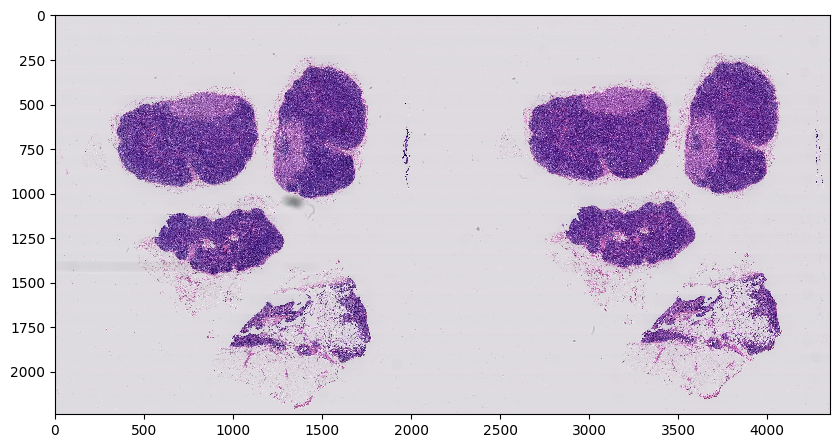

In [0]:
# Example: read the entire slide at level 5

# Higher zoom levels may not fit into memory.
# You can use the below function to extract regions from higher zoom levels 
# without having to read the entire image into ram.

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to the tissue mask to see if the same region contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=Level, 
                         width=slide.level_dimensions[Level][0], 
                         height=slide.level_dimensions[Level][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

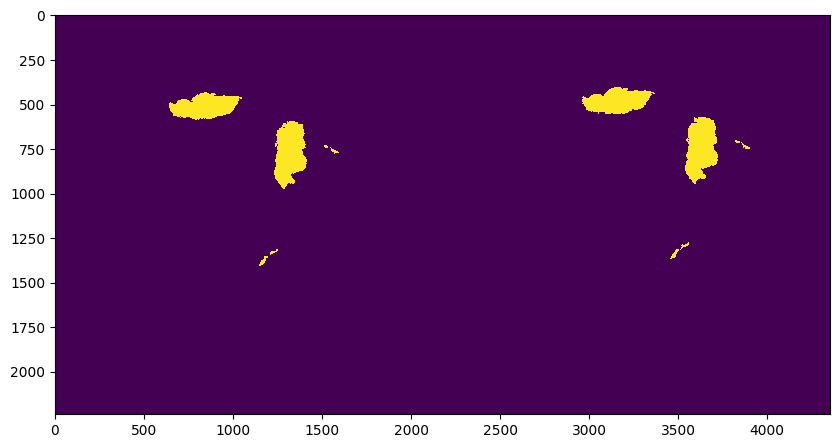

In [0]:
# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=Level, 
                        width=slide.level_dimensions[Level][0], 
                        height=slide.level_dimensions[Level][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

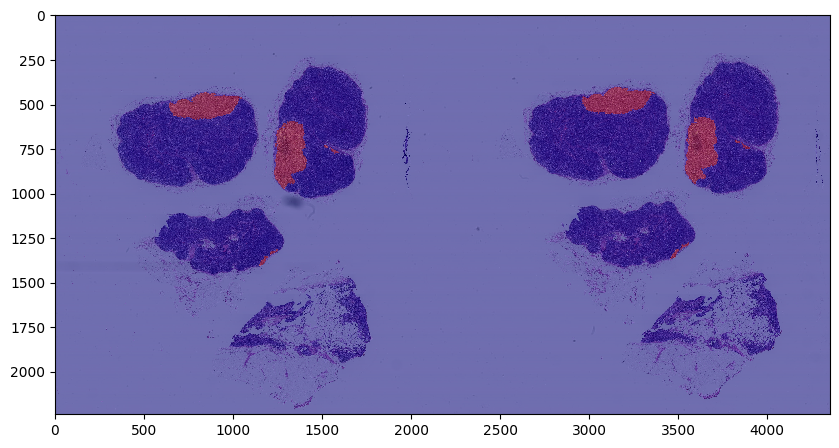

In [0]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

2261809 tissue_pixels pixels (23.2 percent of the image)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


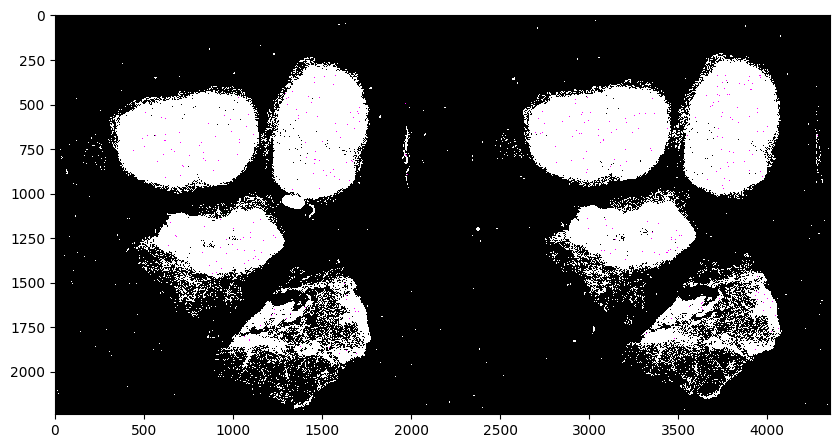

In [0]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

tissue_pixels = find_tissue_pixels(slide_image)
tissue_pixels = list(tissue_pixels)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[1]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 


# apply the mask and convert all the non tissue region into 0s, and keep the image as RGB
def apply_mask_RGB(im, mask, color=(1,1,1)):
    masked = np.zeros(im.shape)
    for x,y in mask: masked[x][y] = color
    masked2 = np.multiply(masked, im)
    return masked2

tissue_regions = apply_mask_RGB(slide_image, tissue_pixels)
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(tissue_regions)

In [0]:
tissue_regions.shape

(2240, 4352, 3)

In [0]:
def resize_image(image, windowSize):
  #resize RGB image to crop out edges to fit windows
  y_factor = int(image.shape[1]/windowSize[1])
  x_factor = int(image.shape[0]/windowSize[0])
  y_lim = y_factor*windowSize[1]
  x_lim = x_factor*windowSize[0]
  resize = image[0:x_lim, 0:y_lim,:]
  
  return resize

In [0]:
# Resize the image for window sliding
window = 128,128
resized_image = resize_image(tissue_regions, window)

In [0]:
resized_image.shape

(2176, 4352, 3)

In [0]:
def resize_mask(image, windowSize):
  #resize mask/grescale image to crop out edges to fit windows
  y_factor = int(image.shape[1]/windowSize[1])
  x_factor = int(image.shape[0]/windowSize[0])
  y_lim = y_factor*windowSize[1]
  x_lim = x_factor*windowSize[0]
  resize = image[0:x_lim, 0:y_lim]

  return resize

In [0]:
# Resize the mask for window sliding
resized_mask = resize_mask(mask_image, window)

In [0]:
resized_mask.shape

(2176, 4352)

In [0]:
def sliding_window(image, mask, stepSize,windowSize):
  assert image.shape[0] == mask.shape[0]
  assert image.shape[1] == mask.shape[1]
  tumor_label =[]
  tissue_label = []
  patches = []
  x_mid = int(windowSize[0]/2)
  y_mid = int(windowSize[1]/2)
  half_step = int(stepSize/2)
  for y in range(0, mask.shape[1]-stepSize, stepSize):
    for x in range(0, mask.shape[0]-stepSize, stepSize):
      mask_patch = mask[x:x + windowSize[0], y:y + windowSize[1]]
      image_patch = image[x:x + windowSize[0], y:y + windowSize[1],:]
      mask_region = mask_patch[(x_mid-half_step):(x_mid+half_step), (y_mid-half_step):(y_mid+half_step)]
      image_region = image_patch[(x_mid-half_step):(x_mid+half_step), (y_mid-half_step):(y_mid+half_step),:]

      if np.sum(image_region)>0:
        tissue_label.append(1)
        patches.append(image_patch)
        if np.sum(mask_region)>0:
          tumor_label.append(1)
        else:
          tumor_label.append(0) 
      else:
        tissue_label.append(0)

  patches = np.array(patches)/255
  patches = np.stack(patches, axis=0)

  return patches, tumor_label, tissue_label


(array([1241.,  102.]), array([0. , 0.5, 1. ]), <a list of 2 Patch objects>)

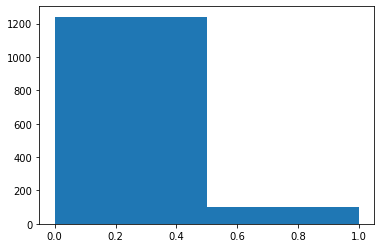

In [0]:
step = 64

# Use the sliding window function to slide to images and mask 
# Output patches for the slide with content and only predict on the center region
patches, tumor_label, tissue_label = sliding_window(resized_image, resized_mask, step, window)

plt.hist(tumor_label, bins=2)

In [0]:
patches.shape

(1343, 128, 128, 3)

In [0]:
len(tumor_label)

1343

In [0]:
len(tissue_label)

2211

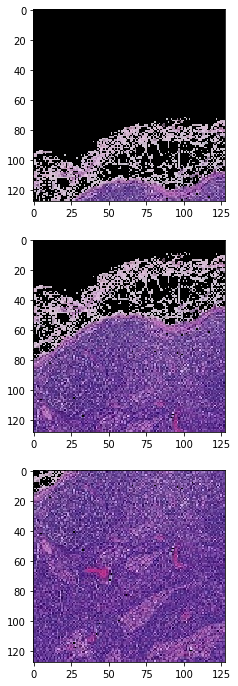

In [0]:
# Output one of the patches
fig, axs = plt.subplots(3,figsize=(10, 12))
axs[0].imshow(patches[100])
axs[1].imshow(patches[101])
axs[2].imshow(patches[102])

In [0]:
os.chdir('/content/drive/My Drive/adl_project/dataset/')

In [0]:
# Save both patches and labels as npz
np.savez(filename+'.npz', patch = patches, label = tumor_label)